# Extracción e ingeniería de características

En este cuaderno vamos a extraer dos características sencillas de los conjuntos de datos <code>setX_0vs1.csv</code>: la "anchura" y la "altura" de la cifra que se ve en una imagen que podemos seleccionar.

Después crearemos dos más a partir de ellas mediante ingeniería de características.

A continuación utilizaremos funciones predefinidas en scikit-learn para crear características.

Finalmente compararemos códigos buscando las diferencias más importantes.

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2024, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2024, URJC (Spain)

    alfredo.cuesta@urjc.es

## Cuaderno

### Imports

In [1]:
import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt

### Cargar datos
Utilizaremos el conjunto de imágenes <code>setX_0vs1.csv</code>.<br>
Las etiquetas <code>setY_0vs1.csv</code> de momento no las necesitamos

In [2]:
pathStr = "../datasets/0vs1/"
[file_X, file_Y] = [pathStr+'setX_0vs1.csv', pathStr+'setY_0vs1.csv']
initial_X = pd.read_csv(file_X, sep=';', header=None, dtype=int)
Y = pd.read_csv(file_Y, sep=';', header=None, dtype=int)

##--- print out the size of the data set
print ('The size of X is ',initial_X.shape)
print ('The size of Y is ',Y.shape)

The size of X is  (1000, 784)
The size of Y is  (1000, 1)


### Reescalar la intensidad de los píxeles a [0,1]

In [3]:
X = initial_X.astype(float)/255.0

In [4]:
''' Print out the size of the given data'''
print("X shape is ", X.shape)
print("Y shape is ", Y.shape)

X shape is  (1000, 784)
Y shape is  (1000, 1)


### Extracción de características
**Altura y Anchura de la cifra**

Vamos a crear **dos características** (*features*) a partir de los píxeles **de una imagen** que elegiremos con la variable <code>selection</code>

Las dos características que vamos a calcular son la **anchura** y **altura** de la imagen.<br>
Para ello en primer lugar se deben sumar las intensidades en la dirección del eje 0 (proyección en el eje horizontal) y del eje 1 (proyección en el eje vertical) <br>
$\rightarrow$ Se obtiene un array de 28 elementos por cada eje
+ La *anchura* = número de columnas entre la primera y la última que tienen más de un $\theta$ % del máximo valor en el array.
+ La *altura*  = número de filas entre la primera y la última que tienen más de un $\theta$ % del máximo valor en el array.<br>

$\theta$  = <code>theta</code> es otra variable que podemos decidir.

El resultado se almacena en el dataframe <code>features_df</code> con dos columnas: <code>width</code> y <code>height</code>

In [25]:
def get_feat_width(x, theta):
    #--width feature
    sum_cols = x.sum(axis=0)
    indc = np.argwhere(sum_cols > theta * sum_cols.max())
    width = indc[-1] - indc[0]    
    return width, sum_cols, indc

def get_feat_height(x, theta):
    #--height feature
    sum_rows = x.sum(axis=1)
    indr = np.argwhere(sum_rows > theta * sum_rows.max())
    height = indr[-1] - indr[0]    
    return height, sum_rows, indr

Aplicamos las funciones que extraen las características a la imagen seleccionada y creamos un dataframe con el resultado.

In [37]:
sel_image = 24 #<- index of the image selected in the data set
theta = 0.3    #<- feature parameter

x_sel = X.iloc[sel_image].values.reshape([28,28])
width_value, sum_cols, indc  = get_feat_width(x_sel,  theta)
height_value, sum_rows, indr = get_feat_height(x_sel, theta)
features_df = pd.DataFrame({'width':width_value, 'height':height_value})

#### Ver los resultados

In [38]:
##------------ Print out the feature vector of the selected image'''
print('The feature vector of the %d-th image is:'%sel_image)
features_df

The feature vector of the 24-th image is:


,width,height
0,11,19


In [39]:
features_df['width'].values[0]

11

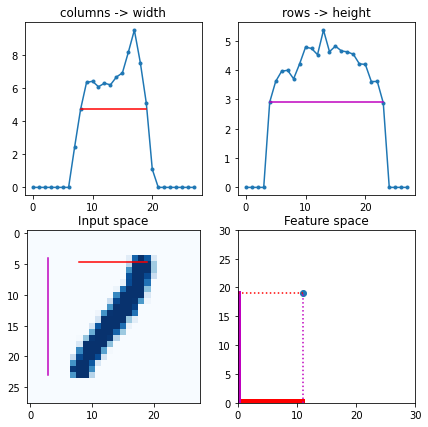

In [40]:
##------------ we can visualize and print the two features 
width  = features_df['width'].values[0]
height = features_df['height'].values[0]
plt.rcParams['figure.figsize'] = [7,7] #<- this makes the figures larger in Jupyter
plt.subplot(221)
plt.plot(sum_cols,'.-')
plt.plot(indc[[0,-1]],sum_cols[indc[[0,0]]],'r')
plt.title('columns -> width')
plt.subplot(222)
plt.plot(sum_rows,'.-')
plt.plot(indr[[0,-1]],sum_rows[indr[[0,0]]],'m')
plt.title('rows -> height')
plt.subplot(223)
plt.imshow(x_sel,cmap='Blues')
plt.plot(indc[[0,-1]],sum_cols[indc[[0,0]]],'r')
plt.plot(sum_rows[indr[[0,0]]],indr[[0,-1]],'m')
plt.title('Input space')
plt.subplot(224)
eps=0.3
plt.plot([0,width],[eps,eps],'r',  linewidth=4)
plt.plot([eps,eps],[0,height],'m', linewidth=4)
plt.plot(width,height,'o',
         [0,width],[height,height],'r:',
         [width,width],[0,height],'m:') 
plt.axis([0,30,0,30])
plt.title('Feature space')
plt.show()

### Ingeniería de características
**Área y relación de aspecto $W/H$**

In [30]:
def get_feat_area(features):
    values = features['width'] * features['height']
    return pd.DataFrame({'area':values})

def get_feat_WoverH(features):
    values = features['width'] / features['height']
    return pd.DataFrame({'WoverH':values})

In [31]:
area = get_feat_area(features_df)
WoverH = get_feat_WoverH(features_df)
features_df = pd.concat([features_df, area, WoverH],axis=1)

#### Ver los resultados

In [32]:
features_df.head()

,width,height,area,WoverH
0,13,19,247,0.684211


### Funciones de características habituales
En el paquete <code>sklearn.preprocessing</code> se pueden encontrar muchos métodos de preprocesado. <br>
Entre ellos ahora destacamos <code>PolynomialFeatures</code> y <code>FunctionTransformer</code>. 

#### Características polinómicas
<code>PolynomialFeatures</code> 
genera una nueva matriz de características que contiene todas las combinaciones polinómicas con grado menor o igual al grado especificado. <br>
Por ejemplo, el ejemplo viene dado por 2 características $[a,b]$, las características polinómicas de grado 2 son $[1, a, b, a^2, ab, b^2]$.

Vamos a extender el vector de características de la imagen seleccionada: <code>features_df</code>$\rightarrow$<code>polyfeat_df</code>

In [33]:
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 2
poly = PolynomialFeatures(poly_degree).set_output(transform="pandas") #<- scikit-learn 1.3.0 required
poly.fit(features_df)
polyfeat_df = poly.transform(features_df)

In [34]:
polyfeat_df

,1,width,height,area,WoverH,width^2,width height,width area,width WoverH,height^2,height area,height WoverH,area^2,area WoverH,WoverH^2
0,1.0,13.0,19.0,247.0,0.684211,169.0,247.0,3211.0,8.894737,361.0,4693.0,13.0,61009.0,169.0,0.468144


#### Características mediante funciones arbitrarias
<code>FunctionTransformer</code> 
genera una nueva característica a partir de una función especificada.<br>
Por ejemplo, podemos convertir todas las características a su logaritmo en base 10<br>
 (como estamos usando pandas y log10 es de numpy tendremos un warning pero funciona)

Vamos a extender el vector de características de la imagen seleccionada: <code>features_df</code>$\rightarrow$<code>newfeat_df</code>

In [35]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log10).set_output(transform="pandas") #<- scikit-learn 1.3.0 required
transformer.fit(features_df)
newfeat_df = transformer.transform(features_df)

In [36]:
newfeat_df

,width,height,area,WoverH
0,1.113943,1.278754,2.392697,-0.16481


## Resumen

En las celdas de arriba hemos extraido dos características a partir de una imagen.

Al principio, la imagen $x$(escalada al intervalo unidad) se puede considerar como un punto en el espacio ${[0,1]}^{28\times28}$. <br>
Sin embargo no todos los píxeles aportar información útil. 

La **extracción de características** consiste en extraer la información que pueda ser relevante para describir el dato de entrada *crudo*.<br>
En este caso, hemos diseñado una manera de extraer la *altura* y la *anchura* del número de entrada.
Este método se puede ver como dos funciones $f_H$ y $f_W$ que mapean el dato de entrada a una característica

$f_H : {[0,1]}^{28\times28} \longrightarrow \mathbb{R}$, tal que  $f_H(x) = \mathrm{height}, \quad$
y
$\quad f_W : {[0,1]}^{28\times28} \longrightarrow \mathbb{R}$, tal que  $f_W(x) = \mathrm{width}.$

En definitiva, la imagen de resolución $28\times28$ se representa por un punto 2D (height,width), que podemos pintar facilmente.

En la figura se denomina "espacio de entrada" (*input space*) al espacio donde viven los datos de entrada *crudos*, y "espacio de características" (*feature space*) al espacio donde viven las representación de los datos diseñadas o elegidas.

A continuación creamos dos características nuevas, *area* y *WoverH*, a partir de las anteriores haciendo **ingeniería de características**. <br>
Al añadirlas nuestro espacio de características pasa a ser $\mathbb{R}^4$,  o sea que la imagen seleccionada se representa con un vector 4D, que es más dificil de representar en una figura. 

Después hemos visto que scikit-learn tiene métodos para añadir características que se utilizan habitualmnente como las polinómicas o las transformaciones mediante funciones de las que había inicialmente. 

#### Detalles del código

| Extracción de características | Ingeniería de características |
|---|----|
|Las funciones reciben una imagen | Las funciones reciben un DataFrame de características|
|Las funciones devuelven un DataFrame con las características|Las funciones devuelven un DataFrame con las nuevas características|


## Ejercicios

### **Ej.1.**  Extensión para más de 1 imagen

En este cuaderno hemos creado vectores de características (*height*, *width*, ...) para **una** imagen seleccionada de un dataframe.

**Pero** la extracción de características **se debe realizar sobre todos los datos.** 
Por tanto nos conviene tener una función que realice esta tarea sobre un dataframe, no sobre una única imagen.

**Se pide:**

Modificar la función **get_feat_width** para que:
+ Reciba un **dataframe**, del cual sabemos lo que representa cada fila y columna
    - En esta caso cada fila es una imagen de 0 o de 1, serializada en un vector de 784 elementos.
    - Cada columna es el valor de un pixel, escalado al intervalo [0,1]
    - Todas las imágenes son en escala de grises, por lo que no hay 3 canales (R,G,B), sólo 1.
+ Reciba un parametro **theta** para ajustar la característica, por defecto = 0.1    
+ Devuelva un dataframe con una columna llamada **width** y tantas filas como filas tiene el dataframe de entrada

Después crear otra función **get_feat_height** con las mismas características, pero para la altura (**height**)

**Comentario** Recuerda que utilizar bucles es inneficiente cuando se usan lenguajes o bibliotecas optimizadas para vectores como Matlab o Numpy. Hay que intentar pensar en como operar con las matrices N-dimensionales; o al menos intentar operar con matrices 2D. <br>
Por ejemplo, cuando tratamos con imágenes en escala de grises, podemos utilizar el eje 0 para indexarlas, el eje 1 para las filas y el eje 2 para las columnas de la matriz 2D que representa cada imagen. <br>
Así podemos utilizar un for para recorrer cada imagen y luego utilizar los métodos matriciales para evitar recorrer las filas y las columnas.

**Ayuda:** Una matriz de 1000 filas y 784 columnas (1000 x 784) se puede transformar en otra de 1000 x 28 x 28<br>
Prueba el siguiente código para verlo mejor:

    data = X.values                   #<- volcado del dataframe en un numpy array de forma 1000x784 
    data = data.reshape([1000,28,28]) #<- cambiamos la forma de 'data', de matriz 2D pasa a 3D
    plt.imshow(data[15,:,:])          #<- mostrar la imagen número 15 <br>


**¡Cuidado!** Cuando se hace **reshape** para pasar de 2D a 3D con el código de arriba, la matriz 28x28 se forma colocando una fila de 28 elementos sobre otra. Prueba el siguiente código para verlo mejor:

    foo=np.ceil(np.random.rand(2,12)*10)
    print('\n original-------------------\n'); print(foo)
    print('\n reshape([2,3,4])-----------\n'); print(foo.reshape([2,3,4]))

**Alternativa:**
Puedes utilizar el iterador de pandas:

        for ind, row in X.iterrows():
            x = row.values.reshape(28, 28)
            #... y luego hacer cosas con x

### **Ej.2.** Visualizar el conjunto de datos en el espacio de características

1. Utilizando el código del ejercicio 1, muestra en una figura todos los ejemplos del conjunto de datos <code>setX_0vs1.csv</code> utilizando un color y un marcador diferente para la representación 2D de los ceros y de los unos;
por ejemplo circulos amarillos para los ceros y cruces azules para los unos.
1. Prueba diferentes <code>theta</code> para ver como varía la representación del conjunto de datos dado en el espacio de características.

Como habrá muchos pares (anchura,altura) que coincidan, una buena idea es separarlos un poco añadiendo una agitación o *jitter*. En el siguiente código es una función que genera un *jitter* gaussiano, centrado en 0 y con una desviación *sigma*, que además puede ser positivo o negativo, sobre un vector de numpy o una serie de pandas, X.

    def jitter(X,sigma=0.3):
        random_sign = (-1)**np.random.randint(1,3,*X.shape)
        return X + np.random.normal(0,sigma,*X.shape)*random_sign

### **Ej.3.** Crear más características

1. Crear la función **get_features** que reciba un dataframe con las imágenes serializadas y devuelva un dataframe con 8 columnas y 1000 filas.
    - cada fila de los dataframes se corresponden con una imagen
    - las columnas del dataframe resultante serán:
        - <code>width</code>:  anchura estimada de la cifra en la imagen (ya hecho)
        - <code>W_max1</code>: el número de columna donde se encuentra el valor máximo de intensidad proyectada en el eje horizontal.
        - <code>W_max2</code>: el número de columna donde se encuentra el segundo valor máximo de intensidad proyectada en el eje horizontal.
        - <code>W_max3</code>: el número de columna donde se encuentra el tercer valor máximo de intensidad proyectada en el eje horizontal.
        - <code>height</code>: altura estimada de la cifra en la imagen (ya hecho)
        - <code>W_max1</code>: el número de fila donde se encuentra el valor máximo de intensidad proyectada en el eje vertical.
        - <code>W_max2</code>: el número de fila donde se encuentra el segundo valor máximo de intensidad proyectada en el eje vertical.
        - <code>W_max3</code>: el número de fila donde se encuentra el tercer valor máximo de intensidad proyectada en el eje vertical.        
        
2. Crear el dataframe <code>X_feat</code> con estas características para cada una de las imágenes de <code>setX_0vs1.csv</code>
3. Añadir más características mediante las técnicas aprendidas.
4. Visualizar diferentes pares de características usando el mísmo código de colores que arriba.

### **Ej.4.** Explorar las herramientas y guardar los resultados 

1. Explora otros creadores de características del paquete <code>sklearn.preprocessing</code>
1. Para terminar guarda en un fichero CSV el dataframe con las características extraídas. <br>
<u>Sugerencia</u>: Llama al fichero <code>featX_0vs1.csv</code>, y utiliza ';' como caracter separador.